# **Matrix** **Multiplication**

---



Input - 2 matrices of compatible sizes ('m1', 'm2')

Output - Sum of elements of matrix obtained by multiplying 'm1', 'm2'

In [0]:
import numpy as np
import pickle as pk
from google.colab import files


def multiply_matrices(m1, m2):
    if not (m1.shape == m2.shape):
        raise Exception('Matrices are not of the same dimenstion', m1.shape, m2.shape, 'are not compatible')
    prod = m1*m2
    return np.sum(prod)

# **Fully Connected Layer**

---
Neurons in a fully connected layer have full connections to all activations in the previous layer. Their activations can hence be computed with a matrix multiplication followed by a bias offset. 

Input - Input matrix [C x W x H] , weights [(C*W*H) x M] , bias [M x 1]

Output - Output of FC Layer [1 x M]

In [0]:
def fullyconnected(ip, weights, bias):
  out = None
  C, W, H = ip.shape
  reshaped_input = ip.reshape((1, int(C*W*H)))
  out = np.dot(reshaped_input, weights) + bias
  return out

# **Activation Layers**

---

**ReLU (Rectified Linear Unit)**

ReLU layer will apply an elementwise activation function 'max(0,x)'  i.e. thresholding at zero. This leaves the size of the volume unchanged.

![RELU](https://cdn-images-1.medium.com/max/937/1*oePAhrm74RNnNEolprmTaQ.png)




---
**Softmax Activation**

The softmax function squashes the outputs of each unit to be between 0 and 1 and it also divides each output such that the total sum of the outputs is equal to 1.
The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability that any of the classes are true.

![Softmax](https://cloud.githubusercontent.com/assets/14886380/22743247/9eb7c856-ee54-11e6-98ca-a7e03120b1f8.png)




In [0]:
class Activation:
    ## act_type: 0 = ReLU
    ##           1 = Softmax
    ##           2 = Sigmoid
    def __init__(self, ip, act_type):
        self.ip = ip
        self.act_type = act_type
    
    def relu(self):
        input = self.ip  
        relu_out = np.zeros(input.shape)  
        for map_num in range(input.shape[-1]):  
            for r in np.arange(0,input.shape[0]):  
                for c in np.arange(0, input.shape[1]):  
                    relu_out[r, c, map_num] = np.max(input[r, c, map_num], 0) 
        return relu_out 

    def softmax(self):
        out = np.exp(self.ip) 
        return out / np.sum(out)

    def forward_pass(self):
        if (self.act_type == 0):
            return self.relu()
        if (self.act_type == 1):
            return self.softmax()

# **Convolution Layer**


---

Convolution layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. 


![Convolution](https://media.giphy.com/media/i4NjAwytgIRDW/giphy.gif)

# **Zero padding**

---

Sometimes it will be convenient to pad the input volume with zeros around the border. The size of this zero-padding is a hyperparameter. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes


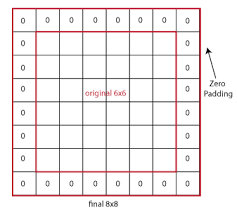

# **Stride**

---

The stride specifies the value with which we slide the filter. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.

**In the gif below, stride is 2**

![alt text](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

In [0]:
class ConvLayer():
    def __init__(self, layer_type, ip, kernels, stride=1, padding=1):
        self.layer_type = layer_type
        self.ip = ip
        self.padding = padding
        self.stride = stride
        self.kernels = kernels
        return
    
    def _conv_maps(self, cmap, kernel):
        ip_size, ip_size = cmap.shape
        kernel_size, kernel_size = kernel.shape
        output_size = int((ip_size - kernel_size + self.padding)/self.stride)
        #### Create a new padded input map
        padded_size = ip_size + self.padding
        cmap_padded = np.zeros([padded_size, padded_size])
        for col in range(padded_size):
            for row in range(padded_size):
                if (row >= ip_size) or (col >= ip_size):
                    break
                cmap_padded[row + self.padding//2, col + self.padding//2] = cmap[row, col]

        #### Compute the output map
        output_map = np.zeros([ip_size, ip_size])
        try:
            for c in range(ip_size):
                for r in range(ip_size):
                    m1 = cmap_padded[c:c+(kernel_size - self.padding//2 + 1), r:r + (kernel_size - self.padding//2 + 1)]
                    output_map[c][r] = multiply_matrices(m1, kernel)
        except Exception as e:
            print(e)
        return output_map
      
    def _conv_3d_maps(self, cmap, kernel):
      num_channels, ip_size, ip_size = cmap.shape
      num_kernel_channels, kernel_size, kernel_size = kernel.shape
      if not (num_channels == num_kernel_channels):
        print("Mismatch in number of channels of kernel and input image")
      output_size = int((ip_size - kernel_size + self.padding)/self.stride)
      output_size = output_size
      #### Create a new padded input map
      padded_size = ip_size + self.padding
      cmap_padded = np.zeros([num_channels, padded_size, padded_size])
      for c in range(num_channels):
        for col in range(padded_size):
            for row in range(padded_size):
                if (row >= ip_size) or (col >= ip_size):
                    break
                cmap_padded[c, row + self.padding//2, col + self.padding//2] = cmap[c, row, col]

      #### Compute the output map
      output_size, output_size = padded_size//self.stride, padded_size//self.stride
      output_map_3d = np.zeros([output_size, output_size])
      stride = self.stride
      try:
          cmap_iter_row = self.padding//2
          cmap_iter_col = self.padding//2
          out_col, out_row = 0, 0
          while (out_row < output_size):
              while (out_col < output_size):
                  m1 = cmap_padded[:, cmap_iter_row - kernel_size//2:cmap_iter_row + kernel_size//2 + 1, cmap_iter_col - kernel_size//2:cmap_iter_col + kernel_size//2 + 1]
                  output_map_3d[out_row][out_col] = np.sum(multiply_matrices(m1, kernel))                  
                  cmap_iter_col += stride
                  out_col += 1
              out_row += 1
              cmap_iter_row += stride

        #   for c in range(ip_size):
        #       for r in range(ip_size):
        #           m1 = cmap_padded[:, c:c+(kernel_size - self.padding//2 + 1), r:r + (kernel_size - self.padding//2 + 1)]
        #           output_map_3d[c][r] = np.sum(multiply_matrices(m1, kernel))
      except Exception as e:
          print(e)
          
      return output_map_3d

    def forward_pass(self):
        this_input = self.ip
        ip_depth, ip_size, ip_size = this_input.shape
        num_kernels, kernel_depth, kernel_size, kernel_size = self.kernels.shape
        outputs = []
        for kernel_id in range(num_kernels):
          out_map = np.zeros((ip_size, ip_size))
          out_map = self._conv_3d_maps(this_input, self.kernels[kernel_id])
#           for map_id, ip_map in enumerate(this_input):
#               out_map_ = self._conv_maps(ip_map, self.kernels[kernel_id][map_id])
#               out_map += out_map_
          outputs.append(out_map)
        return np.array(outputs)

    def test(self):
        cmap = np.ones([5, 10, 10])
        print(cmap.shape)
        self.ip = cmap
        out = self.forward_pass()
        print(out[0].shape)



# **Pooling**

Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations.

![alt text](https://www.cntk.ai/jup/c103d_max_pooling.gif)

In [0]:
def pooling(input, size=2, stride=2):  
    pool_out = np.zeros((np.uint16((input.shape[0] - size + 1)/stride),  
                            np.uint16((input.shape[1] - size + 1)/stride),  
                            input.shape[-1]))  
    for map_num in range(input.shape[-1]):  
        r2 = 0  
        for r in np.arange(0, input.shape[0] - size - 1, stride):  
            c2 = 0  
            for c in np.arange(0, input.shape[1] - size-1, stride):  
                pool_out[r2, c2, map_num] = np.max(input[r:r+size, c:c+size])  
                c2 = c2 + 1  
            r2 = r2 +1  
	return pool_out

# Load Pre Trained Model Weights

Load pre trained model weights, trained on CIFAR 10 dataset

In [0]:
def uploader():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('user uploaded file {name} with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [0]:
def loader(input_weights_file):
  weights = pk.load(open(input_weights_file, 'r'))
  return weights

# **Model Definition**


![alt text](https://raw.githubusercontent.com/IshaanMudgal/IITB-DL-Workshop/master/Capture.PNG)

In [0]:
import numpy as np

inputs = np.random.random((3, 32, 32))
end_points = {}
NUM_CLASSES = 3
uploader()
filename = ''
m_weights = loader(filename)

### Load preweights for the network ###
layer1_kernels = m_weights['conv2d_1']
layer2_kernels = m_weights['conv2d_2']
layer3_weights = m_weights['dense_3']
layer4_weights = m_weights['dense_4']

##### ConvLayer1 #####
layer1_kernels = np.random.random((32, 3, 3, 3))
layer1_stride = 1
layer1_padding = 2
layer1 = ConvLayer(1, inputs, layer1_kernels, layer1_stride, layer1_padding)
layer1_out = layer1.forward_pass()
end_points['convlayer1'] = layer1_out
print("convlayer1 output ready")


In [0]:
##### Act1 #####
act1_inputs = layer1_out
act1 = Activation(act1_inputs, 0)
act1_outs = act1.forward_pass()
end_points['act1'] = act1_outs

##### ConvLayer2 #####
layer2_inputs = act1_outs
layer2_kernels = np.random.random((64, 32, 3, 3))
layer2_stride = 2
layer2_padding = 2
layer2 = ConvLayer(2, layer2_inputs, layer2_kernels, layer2_stride, layer2_padding)
layer2_out = layer2.forward_pass()
end_points['convlayer2'] = layer2_out
print("conv2 outputs ready")

##### Act2 #####
act2_inputs = layer2_out
act2 = Activation(act2_inputs, 0)
act2_outs = act2.forward_pass()
end_points['act2'] = act2_outs
print(act2_outs.shape)

In [0]:
##### Dense 3 #####
layer3_inputs = act2_outs
layer3_weights = np.random.rand(65536, 1024)
layer3_bias = np.random.rand(1024)
layer3_out = fullyconnected(layer3_inputs, layer3_weights, layer3_bias)
## Normalization
layer3_outs = layer3_out/np.max(layer3_out)
end_points['FC'] = layer3_out


In [0]:
##### Dense 3 #####
layer4_inputs = layer3_outs
layer4_weights = np.random.rand(1024, NUM_CLASSES)
layer4_bias = np.random.rand(NUM_CLASSES)
layer4_out = fullyconnected(layer4_inputs, layer4_weights, layer4_bias)
end_points['FC'] = layer4_out
layer4_out = layer4_out/np.max(layer4_out)



In [0]:
##### final Activation #####
act3_inputs = layer3_out
act3 = Activation(act3_inputs, 1)
act3_outs = act3.forward_pass()
end_points['act3'] = act3_outs

print(end_points['act3'])
